# GAN

GAN(Generative Adversarial Network)

처음 GAN을 제안한 Ian Goodfellow는 GAN을 경찰과 위조지폐범 사이의 게임에 비유하였다. 위조지폐범은 최대한 진짜 같은 지폐를 만들어(생성) 경찰을 속이기 위해 노력하고, 경찰은 진짜 지폐와 가짜 지폐를 완벽히 판별하여 위조지폐범을 검거하는 것을 목표로 한다. 이러한 경쟁적인 학습이 지속되다 보면 어느 순간 위조지폐범은 진짜와 똑같은 위조지폐를 만들 수 있게 되고 경찰은 위조지폐와 실제 화폐를 구분할 수 없는 상태에 이르게 될 것이다. 

위의 제목에서 Generative는 이 방법론이 생성을 목적으로 한다는 것을 의미한다. 방금 든 예에서 위조 지폐범이 시간이 지나면서, 완벽에 가까운 위조지폐를 만드는 것처럼 GAN의 목표는 학습할 때 사용했던 데이터 셋에는 없지만, 실제와 다를바 없는 데이터를 생성하는 것이다. 이 목표를 위해, 위조지폐범을 검거하는 경찰 처럼 적대적(Adversarial)으로 실제 데이터 셋과 생성된 데이터를 잘 분류하는 네트워크를 만들어, 잘 분류하는 분류기 조차 분류 하지 못하는 생성 데이터를 만들도록 한다. 아래의 그림은 GAN의 구조이다. 

<img src="https://datascienceschool.net/upfiles/2aa3f47988b642129b696a4b802d3de9.png" style="width: 100%;">

그림 : GAN의 구조

#### GAN의 Value function 과 목표 

GAN의 value function 
$$
V(D, G) = \mathbb{E}_{x \tilde{} p_{data}(x)}[\log D(x)] + \mathbb{E}_{z \tilde{} p_z(z)}[\log(1 - D(G(z)))]  
$$

GAN의 목표 ; min max problem
$$
D,G = \min_G \max_D V(D,G)
$$

#### GAN의 학습과정 

먼저, Generator는 고정하고 Discriminator가 위에서 정의한 Value Function $V(D, G)$를 최대화한다. 의미적으로는 진짜 데이터에 대해서는 1을 출력하고, 생성된 가짜 데이터에 대해서는 0을 출력하여, $V(D, G) \approx 0$ 으로 수렴하도록 한다. 그 다음으로, 이번엔, Discriminator를 고정하고 Generator가 $\mathbb{E}_{z \tilde{} p_z(z)}[\log(1 - D(G(z)))]$를 최소화 하도록, 즉 $D(G(z)) \approx 1$으로 수렴하도록 최적화 한다. 

$$
\max_D V(D,G) = \max_D \mathbb{E}_{x \tilde{} p_{data}}[\log D(x)] + \mathbb{E}_{z \tilde{} p_z}[\log (1 - D(G(z)))]
$$

#### Optimal Solution

결국에 $p(G(z))$가 $p(x)$ 와 같아지면, 학습이 성공한 것이다. 

### GAN 구현 

* GAN 모델은 학습시키기가 아주 어렵기로 유명하다. 2014년에 소개되고 나서도, 한동안 학습을 성공시킨 사례를 찾아보기 힘들었다. 2015년 `Deep Convolutional GAN` 이른바 `DCGAN`이 수많은 실험 끝에, 학습이 잘되는 구조를 찾았다고 발표한 후, GAN의 인기가 불붙듯이 퍼져나갔다. 

그럼에도 여전히 GAN을 학습시키는 것은 매우 어려운 일이다. 아래에 지금까지 알려진 GAN을 학습시키는 기술들을 나열했다. 이 기술들은 이론적인 기반이 있다기 보다, 대부분 실험적이고 휴리스틱하게 만들어진 것이다. 

1. Generator의 마지막 Layer에 Sigmoid(Logistic) 대신 Tanh 활성화 함수로 대체 한다. 
2. $z$를 샘플링 할 때, Uniform 분포가 아닌 Gaussian 정규분포를 사용하여 샘플링 한다. 
3. Dropout과 Label에 노이즈를 주는 것, 학습이 정체되는 것을 방지해준다. 
4. Convolution Filter의 크기를 stride로 나누어지는 수로 설정해준다. 

이것들 이외에도 많은 기술들이 있다. 
 [추천 참고 링크](https://github.com/soumith/ganhacks)

In [1]:
import warnings
warnings.simplefilter("ignore")  # warning 출력 방지

from keras import layers
from keras.datasets import mnist
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam

latent_dim = 100
height = 28
width = 28
channels = 1

Using TensorFlow backend.


### Generator

In [2]:
generator_input = layers.Input(shape=(latent_dim,))
x = layers.Dense(128 * 7 * 7)(generator_input)
x = layers.Reshape((7, 7, 128))(x)
x = layers.Conv2DTranspose(128, 4, strides=2, padding='same')(x)
x = layers.Conv2D(128, 4, padding='same')(x)
x = layers.BatchNormalization(momentum=0.8)(x)
x = layers.ReLU()(x)
x = layers.Conv2DTranspose(128, 4, strides=2, padding='same')(x)
x = layers.Conv2D(64, 4, padding='same')(x)
x = layers.BatchNormalization(momentum=0.8)(x)
x = layers.ReLU()(x)
x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)

generator = Model(generator_input, x)
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 128)       262272    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       262272    
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 14, 14, 128)       0         
__________

### Discriminator

In [3]:
discriminator_input = layers.Input(shape=(height, width, channels))
x = layers.Conv2D(32, 3, strides=2, padding='same')(discriminator_input)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Dropout(0.2)(x)
x = layers.Conv2D(64, 4, strides=2, padding='same')(x)
x = layers.BatchNormalization(momentum=0.8)(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Dropout(0.2)(x)
x = layers.Conv2D(128, 4, strides=2, padding='same')(x)
x = layers.BatchNormalization(momentum=0.8)(x)
x = layers.LeakyReLU()(x)
x = layers.Dropout(0.2)(x)
x = layers.Conv2D(256, 4, strides=1, padding='same')(x)
x = layers.BatchNormalization(momentum=0.8)(x)
x = layers.LeakyReLU()(x)
x = layers.Dropout(0.2)(x)
x = layers.Flatten()(x)
x = layers.Dense(1, activation='sigmoid')(x)

discriminator = Model(discriminator_input, x)
discriminator_optimizer = Adam(lr=0.0002, beta_1=0.5)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy', metrics=['accuracy'])
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 64)          32832     
_________________________________________________________________
batch_normalization_3 (Batch (None, 7, 7, 64)          256       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 64)          0         
__________

### GAN 

In [4]:
gan_input = layers.Input(shape=(latent_dim,))

# Discriminator는 학습 하지 않도록 설정 
discriminator.trainable = False
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)

gan_optimizer = Adam(lr=0.0002, beta_1=0.5)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

### 학습 

In [5]:
(X_train, _), (_, _) = mnist.load_data()

# Generator의 마지막 활성화 함수를 'tanh(.)'를 사용했기 때문에, (-1 ~ 1) 로 스케일링 해준다.
X_train = X_train.astype(np.float32) / 127.5 - 1 
X_train = np.expand_dims(X_train, axis=-1)

In [6]:
batch_size = 32

def train(epochs, print_step=100):
    history = []
    for epoch in range(epochs):
        
        # 실제 이미지 Batch 추출
        real_images = X_train[np.random.randint(0, X_train.shape[0], batch_size)]
        real_label = np.ones((batch_size, 1))
        
        # 이미지 생성
        noise = np.random.normal(0, 1, size=(batch_size, latent_dim))
        generated_images = generator.predict(noise)
        fake_label = np.zeros((batch_size, 1))
        
        # label에 Noise 추가 
        real_label += 0.05 * np.random.normal(0, 1, size=real_label.shape)
        fake_label += 0.05 * np.random.normal(0, 1, size=fake_label.shape)
        
        # discriminator 학습
        d_loss_real = discriminator.train_on_batch(real_images, real_label)
        d_loss_fake = discriminator.train_on_batch(generated_images, fake_label)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        # Generator 학습
        g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

        # 기록
        record = (epoch, d_loss[0], g_loss[0])
        history.append(record)

        if epoch % print_step == 0:
            print("%5d D loss: %.3f, G loss: %.3f" % record)
        
    return history

In [7]:
%%time
history500 = train(500, 100)

    0 D loss: 1.185, G loss: 1.034
  100 D loss: 0.855, G loss: 1.635
  200 D loss: 0.823, G loss: 1.165
  300 D loss: 0.728, G loss: 1.298
  400 D loss: 0.826, G loss: 0.984
CPU times: user 23.9 s, sys: 2.12 s, total: 26 s
Wall time: 19.6 s


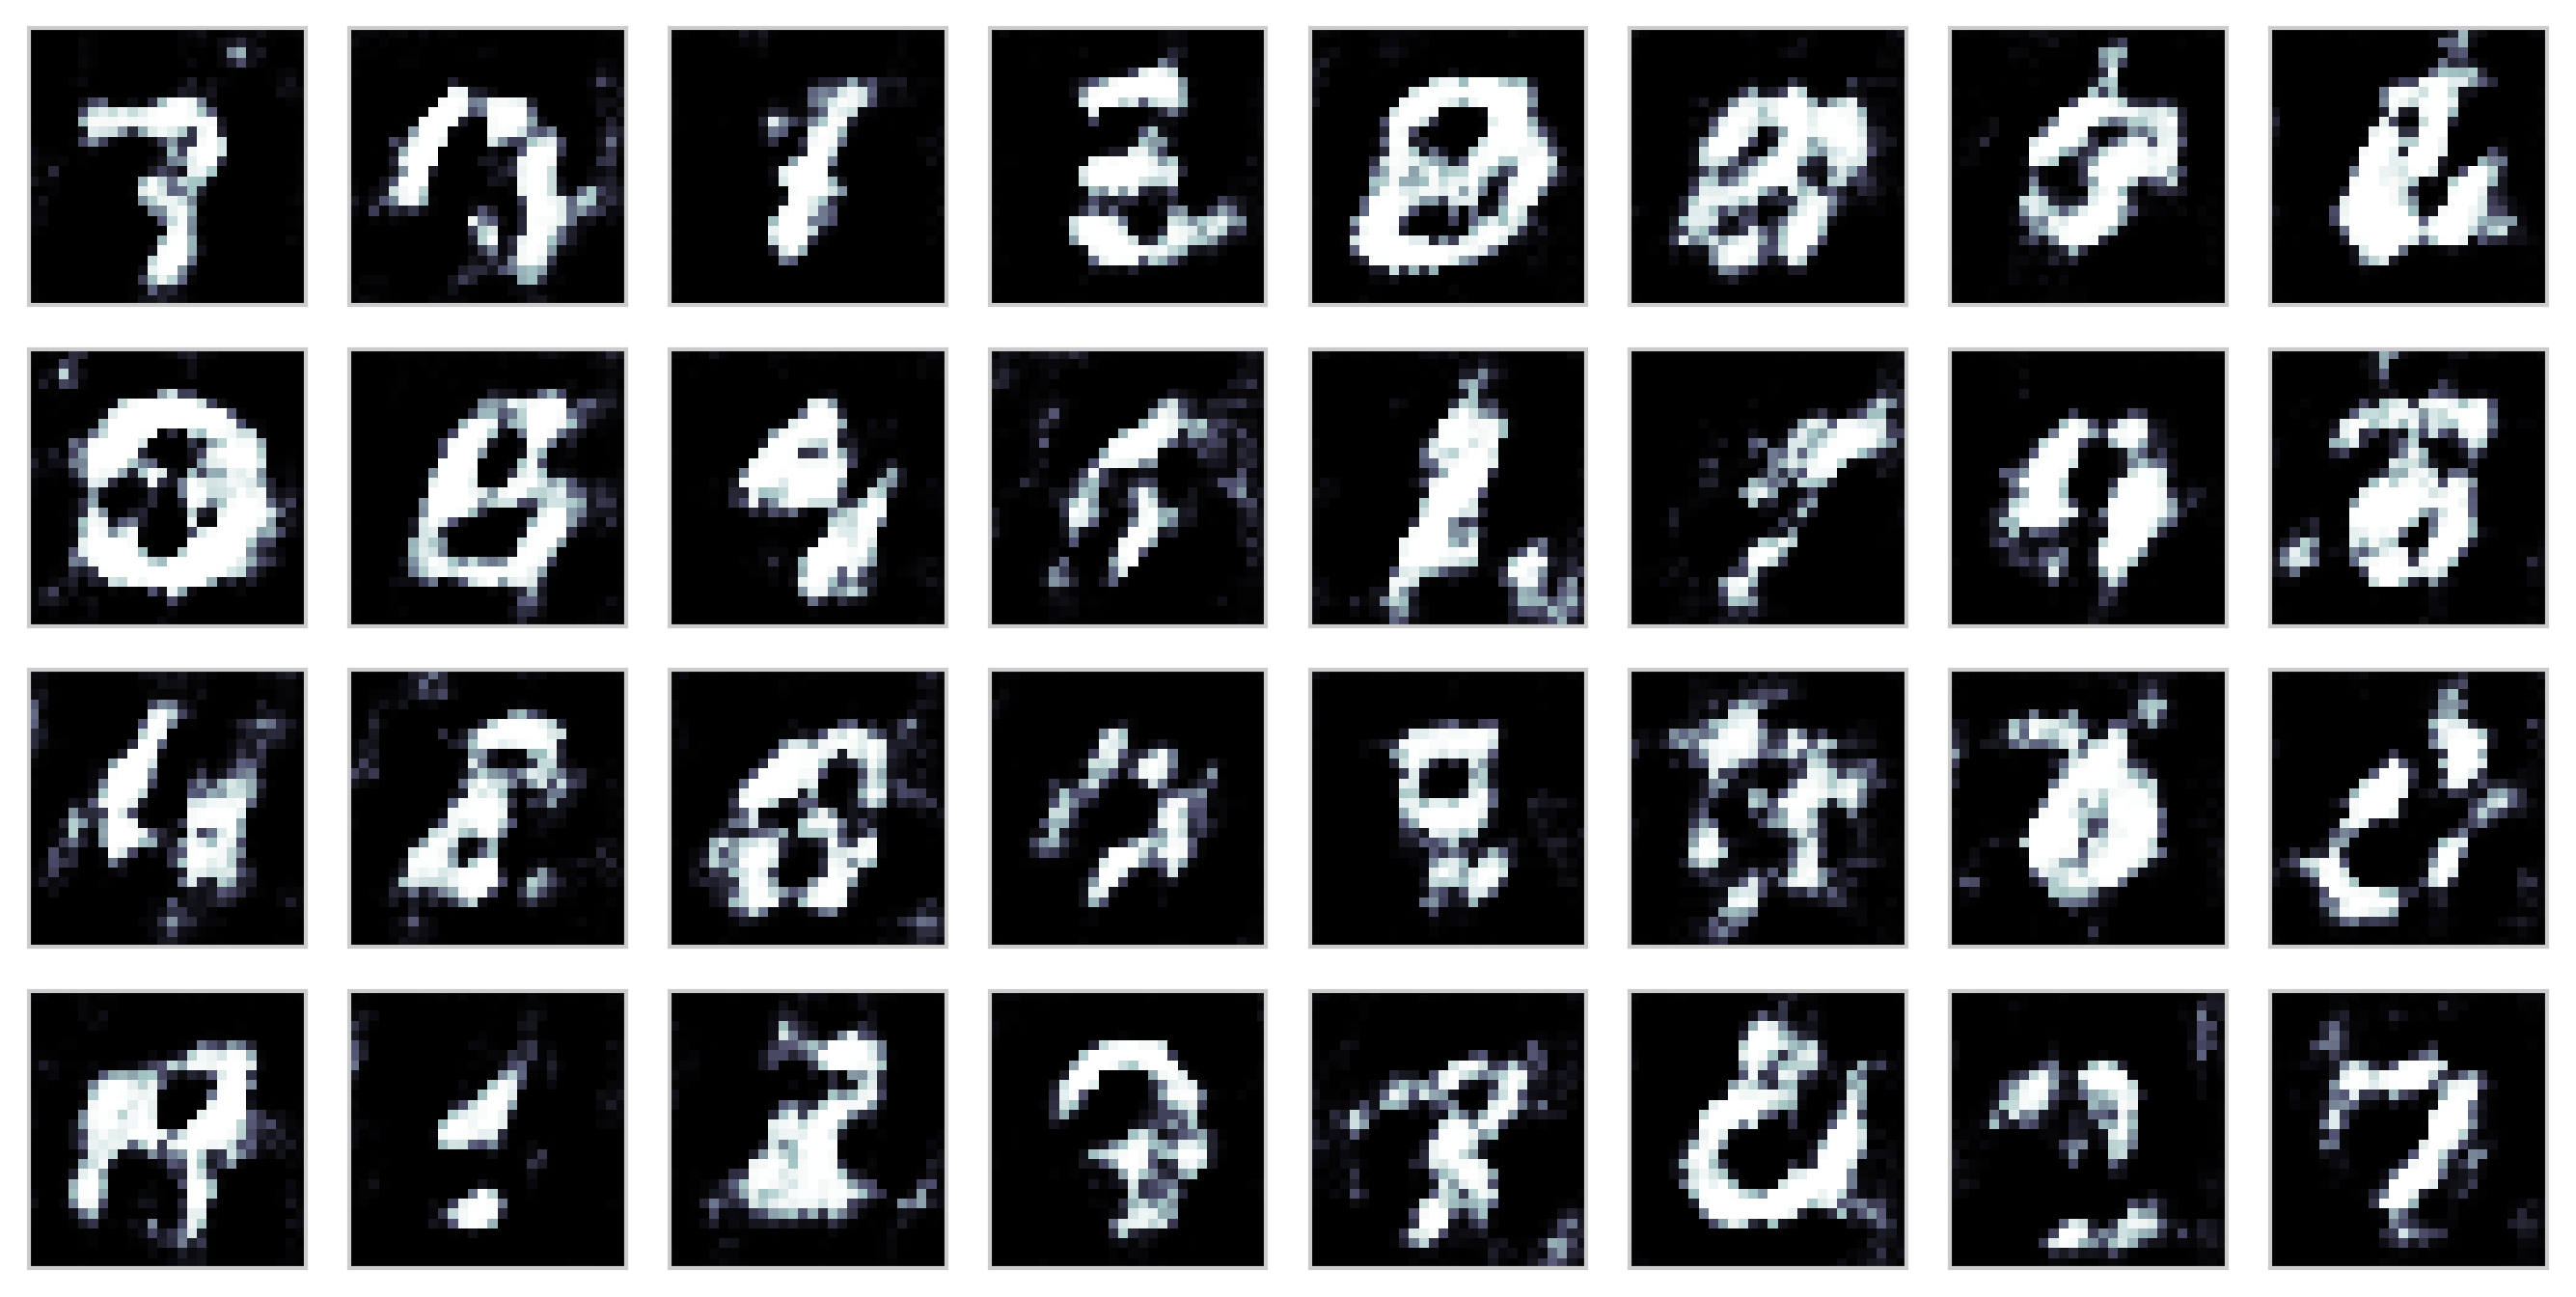

In [8]:
def show_images(generated_images, n=4, m=8, figsize=(9, 5)):
    fig = plt.figure(figsize=figsize)
    plt.subplots_adjust(top=1, bottom=0, hspace=0, wspace=0.05)
    for i in range(n):
        for j in range(m):
            k = i * m + j
            ax = fig.add_subplot(n, m, i * m + j + 1)
            ax.imshow(generated_images[k][:, :, 0], cmap=plt.cm.bone)
            ax.grid(False)
            ax.xaxis.set_ticks([])
            ax.yaxis.set_ticks([])
    plt.tight_layout()
    plt.show()


noise_data = np.random.normal(0, 1, size=(32, latent_dim))
show_images(0.5 * generator.predict(noise_data) + 0.5)

In [9]:
%%time
history5000 = train(4500, 500)

    0 D loss: 0.934, G loss: 1.128
  500 D loss: 0.740, G loss: 0.880
 1000 D loss: 0.670, G loss: 1.123
 1500 D loss: 0.683, G loss: 0.989
 2000 D loss: 0.818, G loss: 0.957
 2500 D loss: 0.642, G loss: 0.993
 3000 D loss: 0.600, G loss: 1.336
 3500 D loss: 0.703, G loss: 1.211
 4000 D loss: 0.537, G loss: 1.262
CPU times: user 2min 46s, sys: 11.9 s, total: 2min 58s
Wall time: 2min 2s


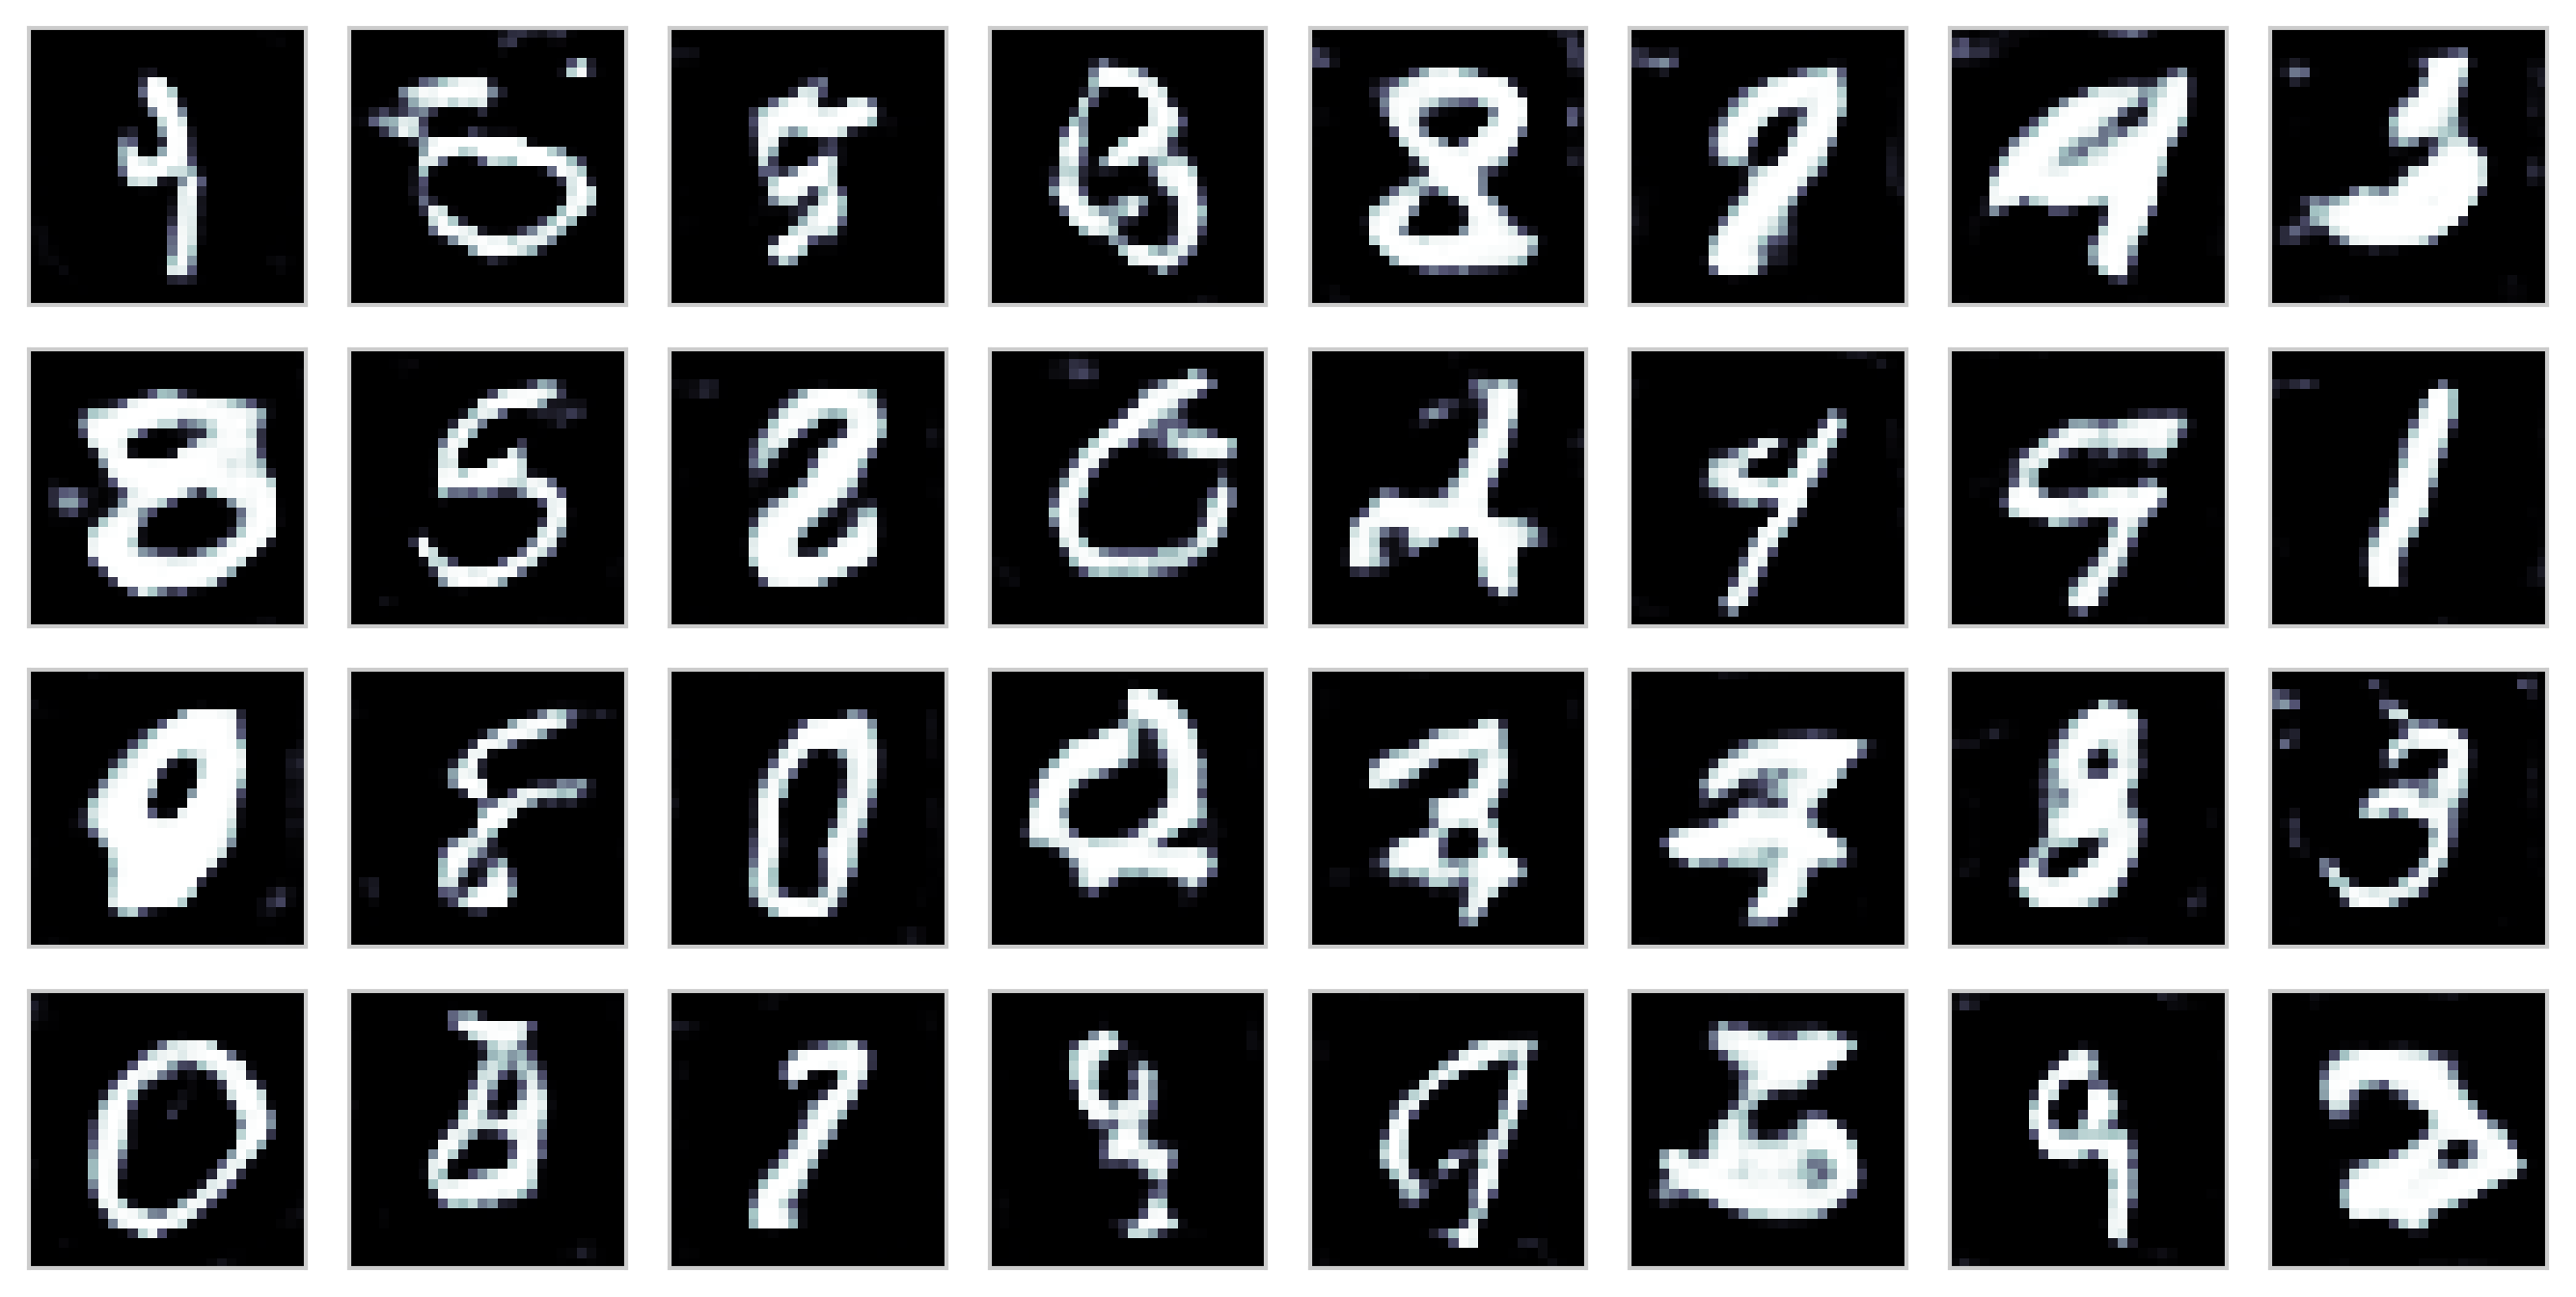

In [10]:
show_images(0.5 * generator.predict(noise_data) + 0.5)

    0 D loss: 0.617, G loss: 1.313
 2000 D loss: 0.300, G loss: 2.035
 4000 D loss: 0.522, G loss: 1.382
 6000 D loss: 0.251, G loss: 1.356
 8000 D loss: 0.328, G loss: 2.727
10000 D loss: 0.136, G loss: 2.238
12000 D loss: 0.378, G loss: 1.655
14000 D loss: 0.200, G loss: 1.394


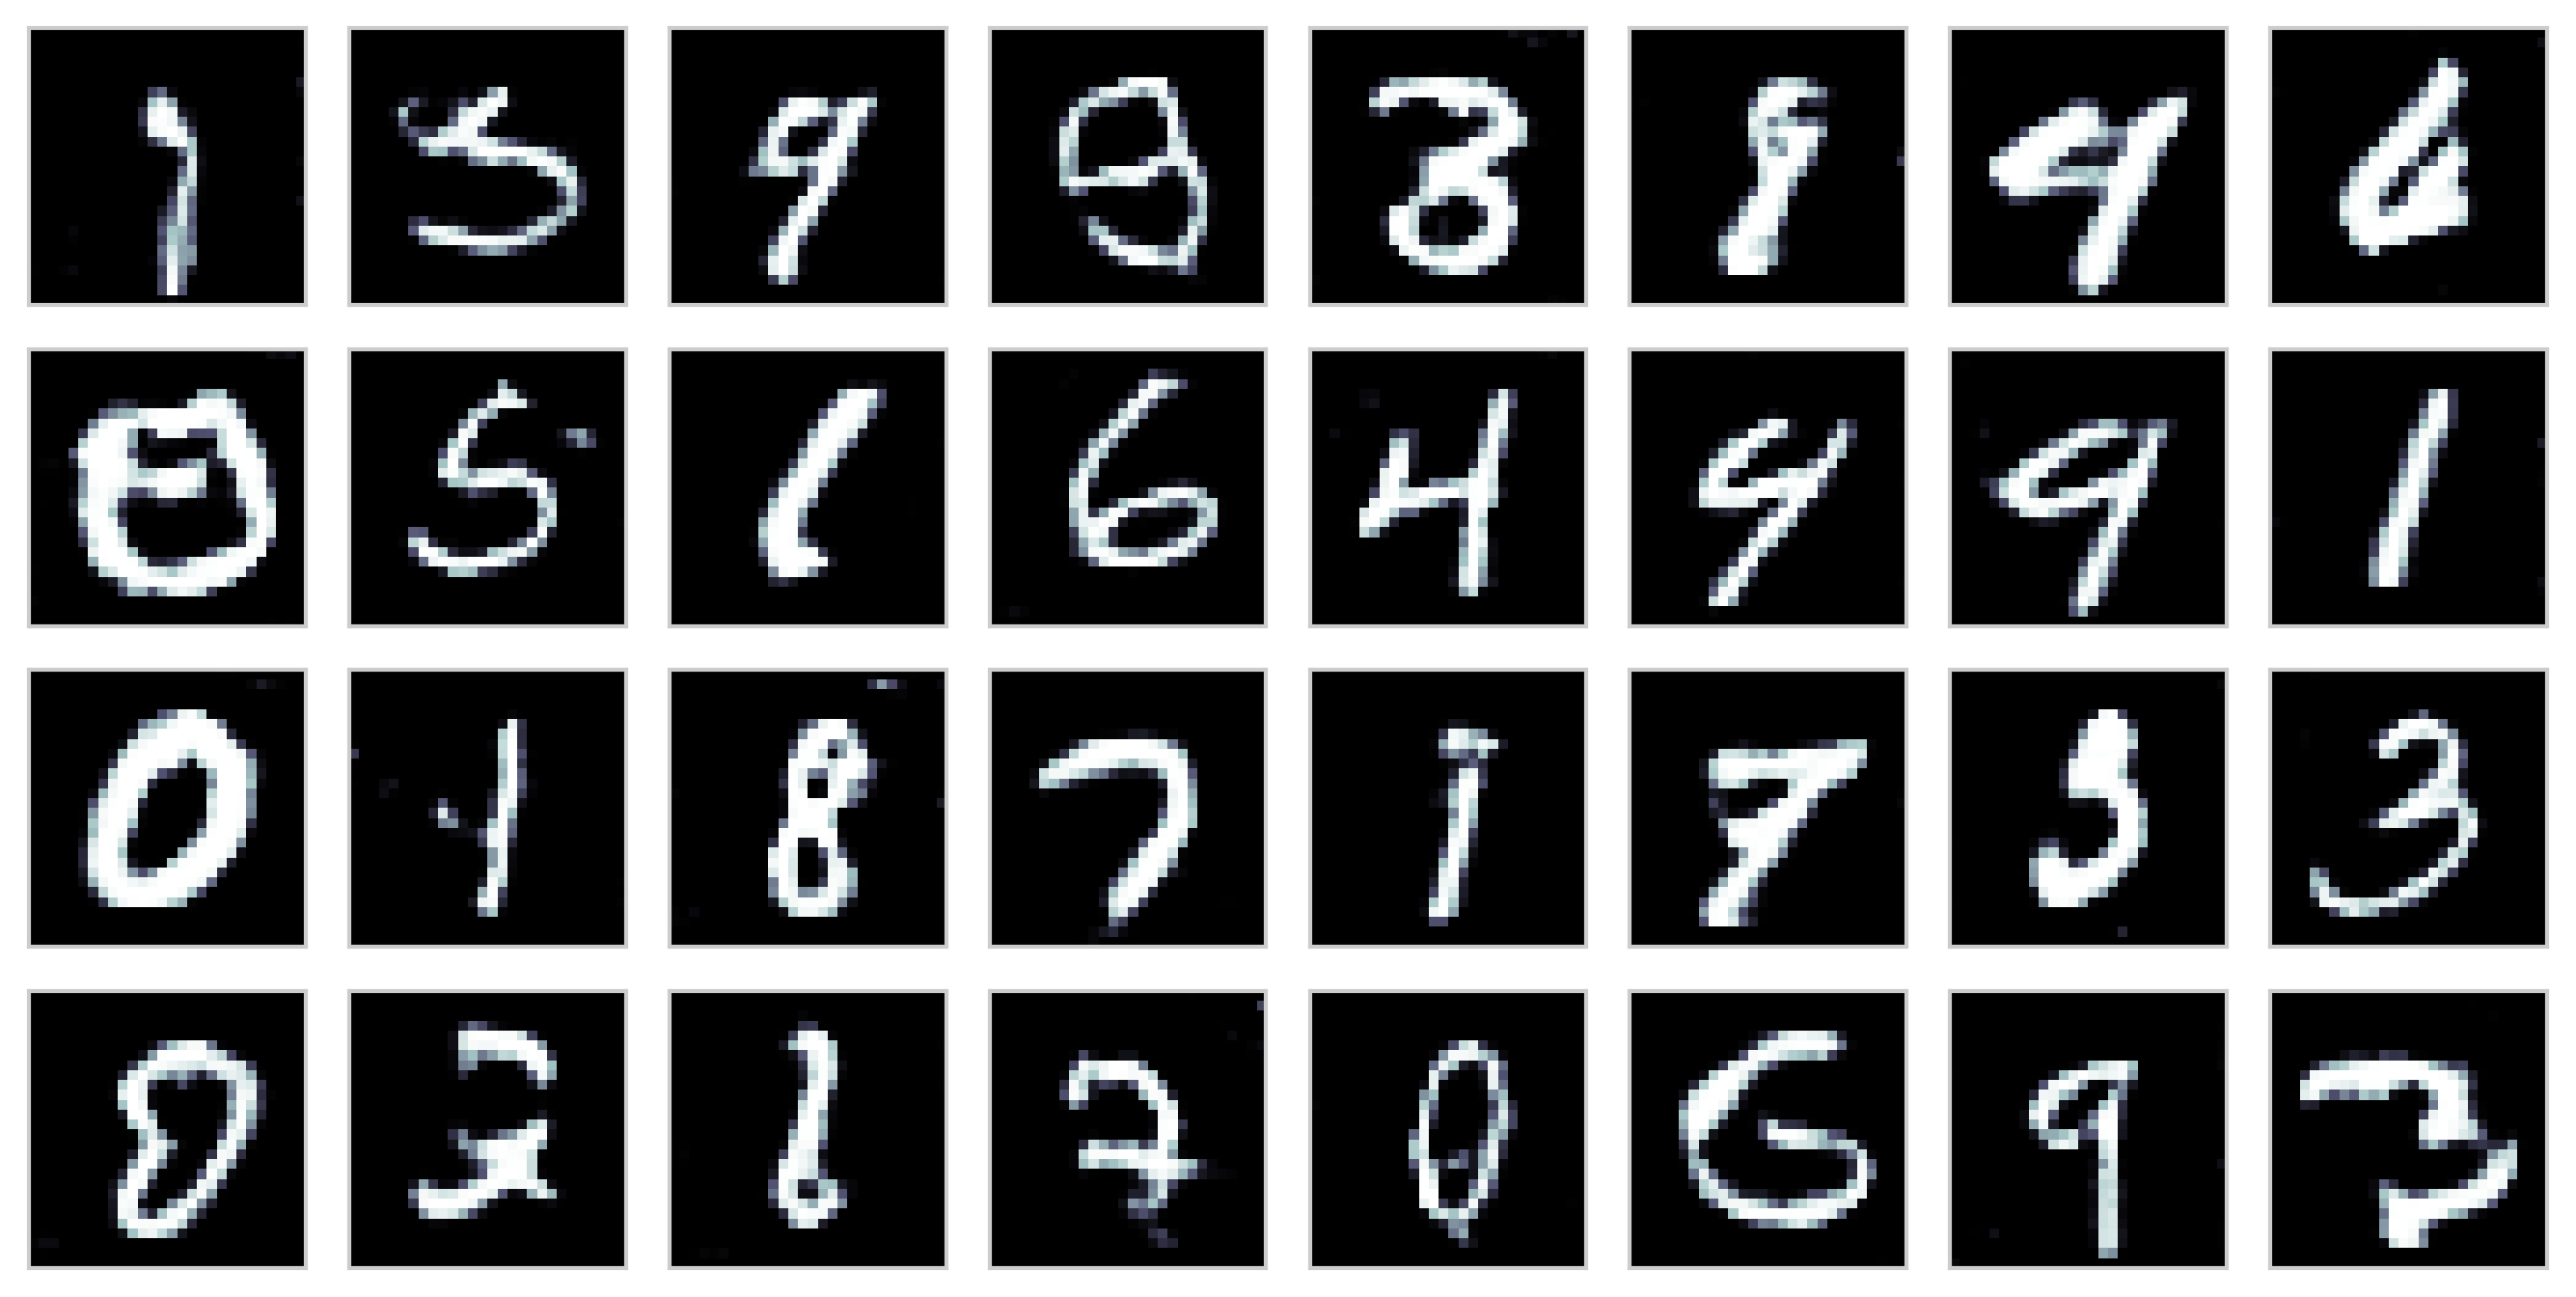

CPU times: user 9min 13s, sys: 40.9 s, total: 9min 54s
Wall time: 6min 44s


In [11]:
%%time
history20000 = train(15000, 2000)
show_images(0.5 * generator.predict(noise_data) + 0.5)

In [12]:
def save_models(title, epoch):
    generator.save("dcgan_generator_{}_{}.hdf5".format(title, epoch))
    discriminator.save("dcgan_discriminator_{}_{}.hdf5".format(title, epoch))
    gan.save("dcgan_combined_{}_{}.hdf5".format(title, epoch))

save_models("mnist", 20000)

## Face Generation

In [13]:
from sklearn.datasets import fetch_olivetti_faces

X_train = fetch_olivetti_faces().images

latent_dim = 100
height = 64
width = 64
channels = 1

X_train = X_train * 2 - 1 
X_train = np.expand_dims(X_train, axis=-1)

### Generator

In [14]:
generator_input = layers.Input(shape=(latent_dim,))
x = layers.Dense(128 * 16 * 16)(generator_input)
x = layers.Reshape((16, 16, 128))(x)
x = layers.Conv2DTranspose(128, 4, strides=2, padding='same')(x)
x = layers.Conv2D(128, 4, padding='same')(x)
x = layers.BatchNormalization(momentum=0.8)(x)
x = layers.ReLU()(x)
x = layers.Conv2DTranspose(128, 4, strides=2, padding='same')(x)
x = layers.Conv2D(64, 4, padding='same')(x)
x = layers.BatchNormalization(momentum=0.8)(x)
x = layers.ReLU()(x)
x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)

generator = Model(generator_input, x)
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 32768)             3309568   
_________________________________________________________________
reshape_2 (Reshape)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 32, 32, 128)       262272    
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 128)       262272    
_________________________________________________________________
batch_normalization_6 (Batch (None, 32, 32, 128)       512       
_________________________________________________________________
re_lu_3 (ReLU)               (None, 32, 32, 128)       0         
__________

### Discriminator

In [15]:
discriminator_input = layers.Input(shape=(height, width, channels))
x = layers.Conv2D(32, 3, strides=2, padding='same')(discriminator_input)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Dropout(0.2)(x)
x = layers.Conv2D(64, 4, strides=2, padding='same')(x)
x = layers.BatchNormalization(momentum=0.8)(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Dropout(0.2)(x)
x = layers.Conv2D(128, 4, strides=2, padding='valid')(x)
x = layers.BatchNormalization(momentum=0.8)(x)
x = layers.LeakyReLU()(x)
x = layers.Dropout(0.2)(x)
x = layers.Conv2D(256, 4, strides=1, padding='valid')(x)
x = layers.BatchNormalization(momentum=0.8)(x)
x = layers.LeakyReLU()(x)
x = layers.Dropout(0.2)(x)
x = layers.Flatten()(x)
x = layers.Dense(1, activation='sigmoid')(x)

discriminator = Model(discriminator_input, x)
discriminator_optimizer = Adam(lr=0.0002, beta_1=0.5, clipvalue=1.0)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy', metrics=['accuracy'])
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 16, 64)        32832     
_________________________________________________________________
batch_normalization_8 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 16, 16, 64)        0         
__________

### GAN 

In [16]:
gan_input = layers.Input(shape=(latent_dim,))

# Discriminator는 학습 하지 않도록 설정 
discriminator.trainable = False
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)

gan_optimizer = Adam(lr=0.0002, beta_1=0.5, clipvalue=1.0)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

### 학습 

In [17]:
batch_size = 32

def train(epochs, print_step=100):
    history = []
    for epoch in range(epochs):
        
        # 실제 이미지 Batch 추출
        real_images = X_train[np.random.randint(0, X_train.shape[0], batch_size)]
        real_label = np.ones((batch_size, 1))
        
        # 이미지 생성
        noise = np.random.normal(0, 1, size=(batch_size, latent_dim))
        generated_images = generator.predict(noise)
        fake_label = np.zeros((batch_size, 1))
        
        # label에 Noise 추가 
        real_label += 0.05 * np.random.normal(0, 1, size=real_label.shape)
        fake_label += 0.05 * np.random.normal(0, 1, size=fake_label.shape)
        
        # discriminator 학습
        d_loss_real = discriminator.train_on_batch(real_images, real_label)
        d_loss_fake = discriminator.train_on_batch(generated_images, fake_label)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        # Generator 학습
        g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

        # 기록
        record = (epoch, d_loss[0], g_loss[0])
        history.append(record)

        if epoch % print_step == 0:
            print("%5d D loss: %.3f, G loss: %.3f" % record)
            
    return history

In [18]:
%%time
history1000 = train(1000, 100)

    0 D loss: 0.777, G loss: 1.143
  100 D loss: 0.137, G loss: 0.707
  200 D loss: 0.330, G loss: 3.192
  300 D loss: 0.620, G loss: 2.482
  400 D loss: 0.694, G loss: 3.415
  500 D loss: 0.109, G loss: 3.603
  600 D loss: 0.323, G loss: 4.023
  700 D loss: 0.325, G loss: 6.256
  800 D loss: 0.160, G loss: 4.145
  900 D loss: 0.216, G loss: 3.170
CPU times: user 55.5 s, sys: 10.9 s, total: 1min 6s
Wall time: 58.1 s


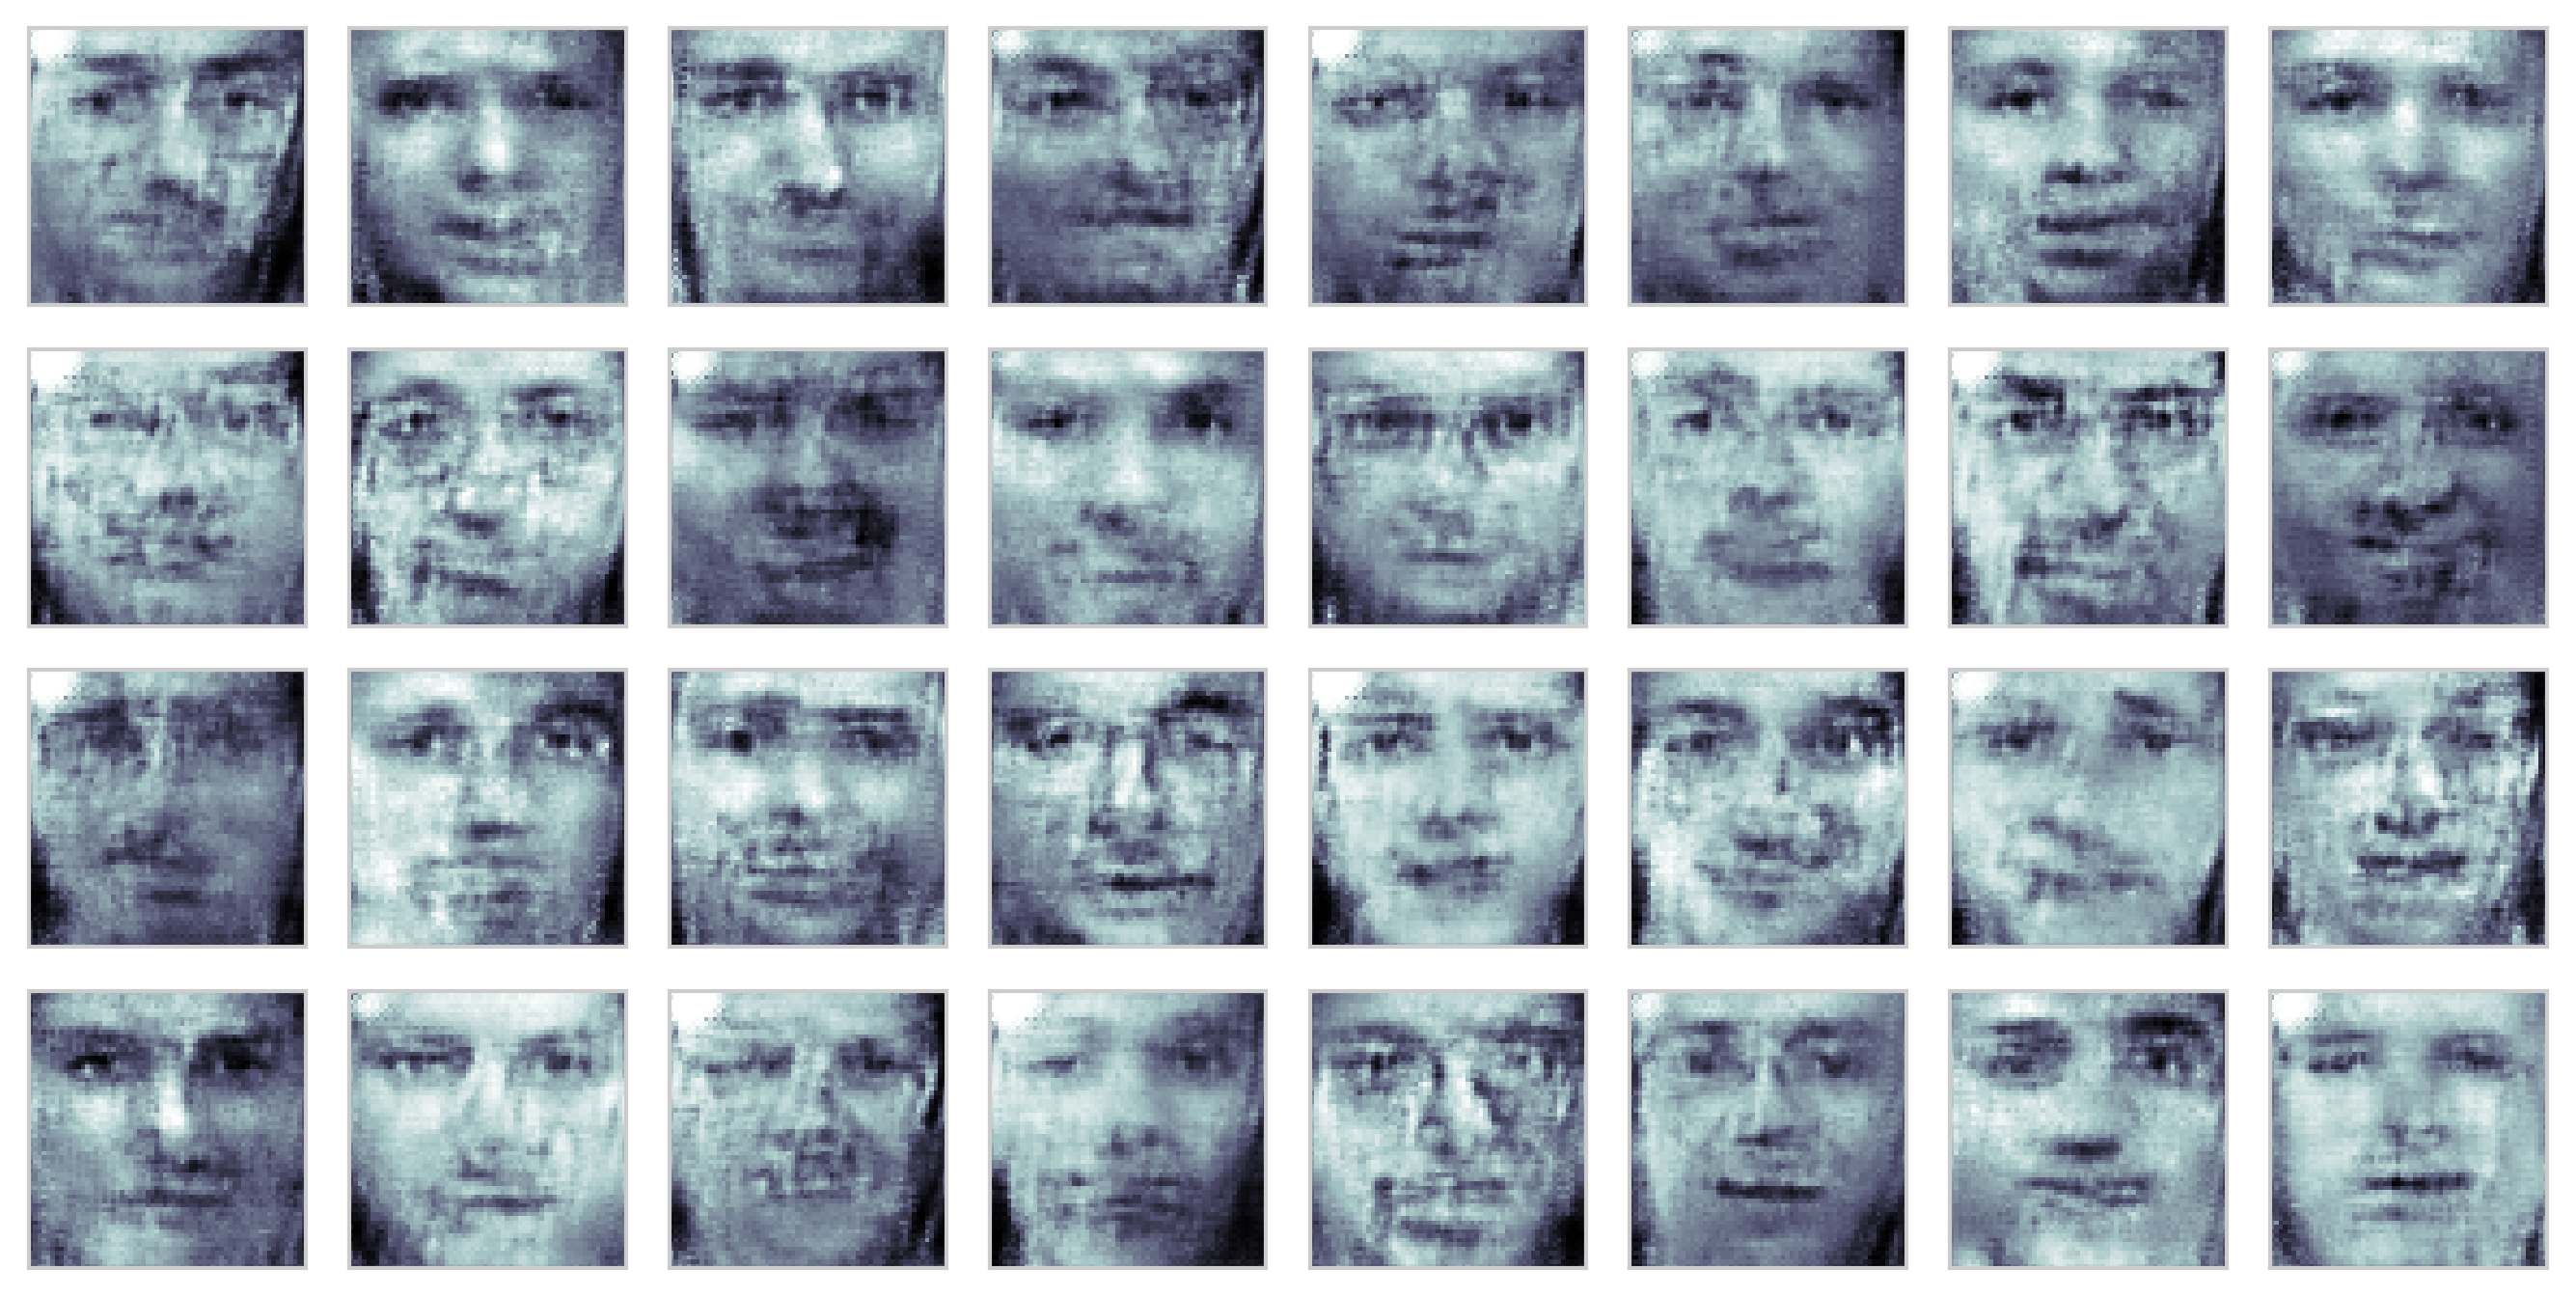

In [19]:
def show_images(generated_images, n=4, m=8, figsize=(9, 5)):
    fig = plt.figure(figsize=figsize)
    plt.subplots_adjust(top=1, bottom=0, hspace=0, wspace=0.05)
    for i in range(n):
        for j in range(m):
            k = i * m + j
            ax = fig.add_subplot(n, m, i * m + j + 1)
            ax.imshow(generated_images[k][:, :, 0], cmap=plt.cm.bone)
            ax.grid(False)
            ax.xaxis.set_ticks([])
            ax.yaxis.set_ticks([])
    plt.tight_layout()
    plt.show()


noise_data = np.random.normal(0, 1, size=(32, latent_dim))
show_images(0.5 * generator.predict(noise_data) + 0.5)

In [20]:
%%time
history20000 = train(19000, 2000)

    0 D loss: 0.249, G loss: 4.455
 2000 D loss: 0.238, G loss: 3.843
 4000 D loss: 0.071, G loss: 4.317
 6000 D loss: 0.070, G loss: 5.193
 8000 D loss: 0.099, G loss: 5.485
10000 D loss: 0.040, G loss: 5.770
12000 D loss: 0.239, G loss: 6.604
14000 D loss: -0.006, G loss: 7.021
16000 D loss: -0.066, G loss: 8.015
18000 D loss: 0.055, G loss: 7.752
CPU times: user 16min 6s, sys: 3min 9s, total: 19min 15s
Wall time: 16min 41s


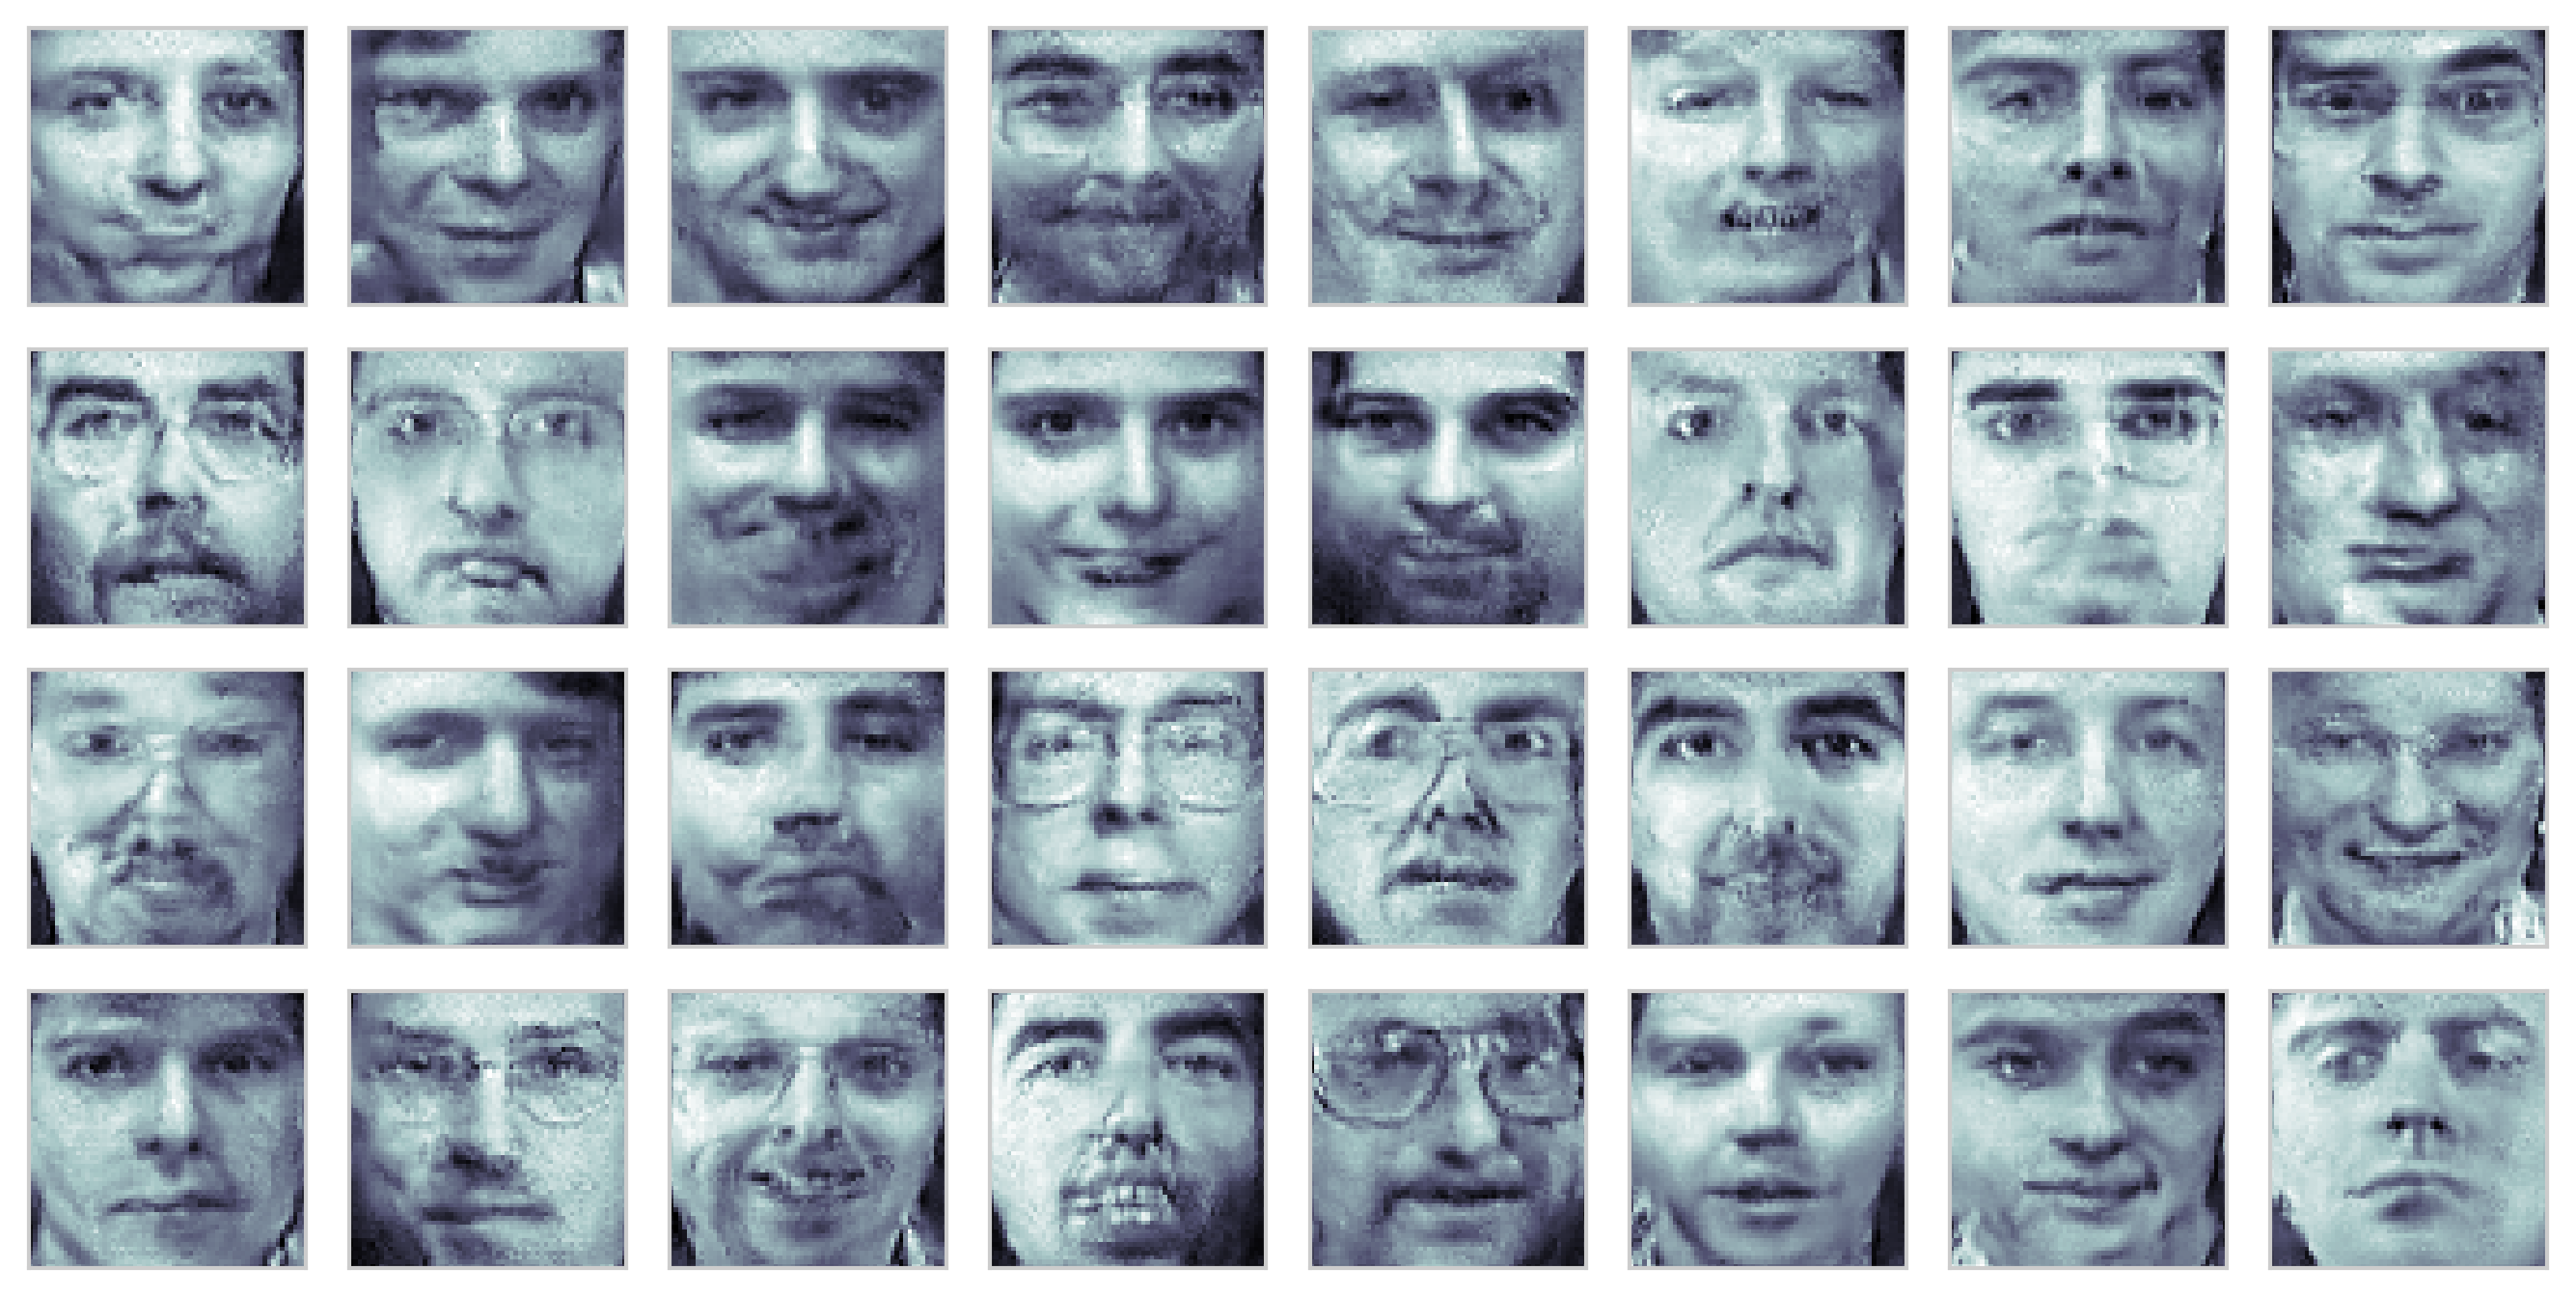

In [21]:
show_images(0.5 * generator.predict(noise_data) + 0.5)
save_models("olivetti", 20000)